🚀 Training models...

📊 Model Comparison Results:


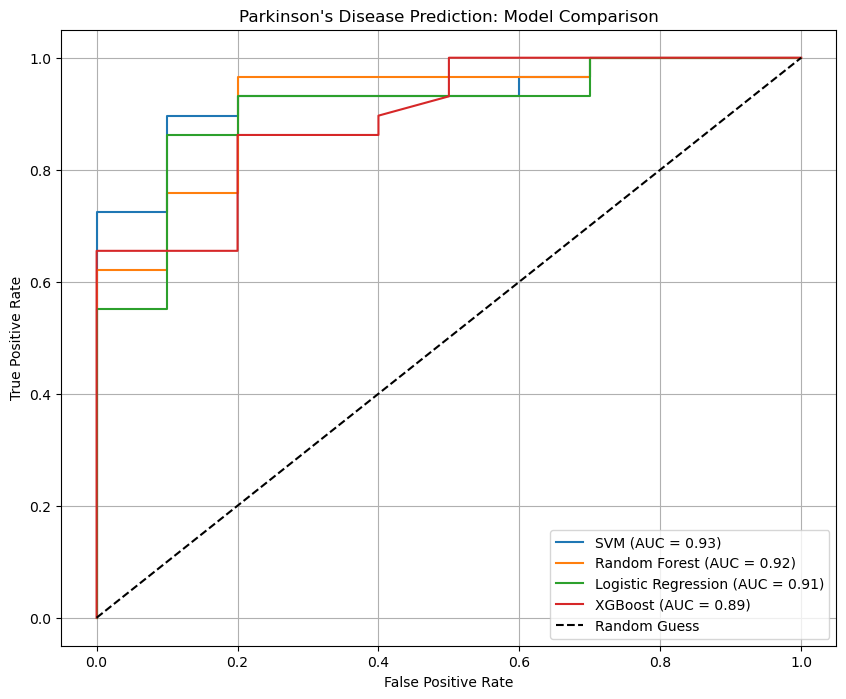


🏆 Best Model: SVM
AUC: 0.93
Classification Report:
              precision    recall  f1-score   support

     Healthy       0.78      0.70      0.74        10
 Parkinson's       0.90      0.93      0.92        29

    accuracy                           0.87        39
   macro avg       0.84      0.82      0.83        39
weighted avg       0.87      0.87      0.87        39


💾 Saved best model as 'best_parkinsons_model.sav'

🩺 Example Clinical Prediction:

Input Features:
Jitter: 0.50%
Shimmer: 0.154 dB
HNR: 24.0
RPDE: 0.57
PPE: 0.12

Clinical Assessment:
Prediction: Healthy
Probability: 14.5%
Risk Factors: High shimmer (0.15 dB), High RPDE (0.57)
Recommended Action: No action needed


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ====================== DATA PREPARATION ======================
def load_data():
    """Load and preprocess Parkinson's dataset"""
    df = pd.read_csv("C:\\Users\\khade\\OneDrive\\Desktop\\Capstone\\parkinsons.csv")
    # Selected 5 key attributes
    X = df[['MDVP:Jitter(%)', 'MDVP:Shimmer(dB)', 'HNR', 'RPDE', 'PPE']]
    y = df['status']
    return X, y

# ====================== MODEL TRAINING ======================
def train_models(X_train, y_train):
    """Train and compare multiple models with optimal settings"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Model configurations
    models = {
        "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    # Train all models
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
    
    return trained_models, scaler

# ====================== EVALUATION ======================
def evaluate_models(models, X_test, y_test, scaler):
    """Compare model performance with ROC curves and metrics"""
    plt.figure(figsize=(10, 8))
    X_test_scaled = scaler.transform(X_test)
    results = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Store metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_proba),
            'report': classification_report(y_test, y_pred, target_names=["Healthy", "Parkinson's"])
        }
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc"]:.2f})')
    
    # Format plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Parkinson\'s Disease Prediction: Model Comparison')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    return results

# ====================== CLINICAL PREDICTION ======================
def predict_parkinsons(model, scaler, jitter, shimmer, hnr, rpde, ppe, threshold=0.3):
    """Make clinically interpretable predictions"""
    input_data = scaler.transform([[jitter, shimmer, hnr, rpde, ppe]])
    proba = model.predict_proba(input_data)[0][1]
    
    # Risk factors
    risks = []
    if jitter > 0.005: risks.append(f"High jitter ({jitter*100:.2f}%)")
    if shimmer > 0.05: risks.append(f"High shimmer ({shimmer:.2f} dB)")
    if hnr < 20: risks.append(f"Low HNR ({hnr:.1f})")
    if rpde > 0.5: risks.append(f"High RPDE ({rpde:.2f})")
    if ppe > 0.2: risks.append(f"High PPE ({ppe:.2f})")
    
    return {
        'prediction': "Parkinson's" if proba >= threshold else "Healthy",
        'probability': f"{proba:.1%}",
        'risk_factors': ", ".join(risks) if risks else "No significant risks",
        'action': "No action needed" if proba < 0.3 else 
                 "Neurologist consult" if proba < 0.7 else 
                 "Immediate specialist evaluation"
    }

# ====================== MAIN EXECUTION ======================
if __name__ == "__main__":
    # Load data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Train and compare models
    print("🚀 Training models...")
    models, scaler = train_models(X_train, y_train)
    
    print("\n📊 Model Comparison Results:")
    results = evaluate_models(models, X_test, y_test, scaler)
    
    # Print metrics for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"AUC: {results[best_model_name]['auc']:.2f}")
    print("Classification Report:")
    print(results[best_model_name]['report'])
    
    # Save best model
    with open('best_parkinsons_model.sav', 'wb') as f:
        pickle.dump({
            'model': models[best_model_name],
            'scaler': scaler,
            'metadata': {
                'features': ['MDVP:Jitter(%)', 'MDVP:Shimmer(dB)', 'HNR', 'RPDE', 'PPE'],
                'auc': results[best_model_name]['auc']
            }
        }, f)
    print("\n💾 Saved best model as 'best_parkinsons_model.sav'")
    
    # Example clinical prediction
    print("\n🩺 Example Clinical Prediction:")
    case = {
        'jitter': 0.00496, 
        'shimmer': 0.154, 
        'hnr': 23.958, 
        'rpde': 0.566424, 
        'ppe': 0.120605
    }
    pred = predict_parkinsons(models[best_model_name], scaler, **case)
    
    print(f"\nInput Features:")
    print(f"Jitter: {case['jitter']*100:.2f}%")
    print(f"Shimmer: {case['shimmer']:.3f} dB")
    print(f"HNR: {case['hnr']:.1f}")
    print(f"RPDE: {case['rpde']:.2f}")
    print(f"PPE: {case['ppe']:.2f}")
    
    print(f"\nClinical Assessment:")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']}")
    print(f"Risk Factors: {pred['risk_factors']}")
    print(f"Recommended Action: {pred['action']}")